In [20]:
!git clone https://github.com/gbrltv/process_meta_learning.git

fatal: destination path 'process_meta_learning' already exists and is not an empty directory.


###Importing meta-features extracted from the event logs

Family of meta-features:


*   Trace length
*   Trace variants
*   Activities
*   Start activities
*   End activities 
*   Entropy



In [21]:
import pandas as pd

df_logs = pd.read_csv("process_meta_learning/results/log_features.csv")
df_logs

,log,n_traces,n_unique_traces,ratio_unique_traces_per_trace,n_events,trace_len_min,trace_len_max,trace_len_mean,trace_len_median,trace_len_mode,trace_len_std,trace_len_variance,trace_len_q1,trace_len_q3,trace_len_iqr,trace_len_geometric_mean,trace_len_geometric_std,trace_len_harmonic_mean,trace_len_skewness,trace_len_kurtosis,trace_len_coefficient_variation,trace_len_entropy,trace_len_hist1,trace_len_hist2,trace_len_hist3,trace_len_hist4,trace_len_hist5,trace_len_hist6,trace_len_hist7,trace_len_hist8,trace_len_hist9,trace_len_hist10,trace_len_skewness_hist,trace_len_kurtosis_hist,ratio_most_common_variant,ratio_top_1_variants,ratio_top_5_variants,ratio_top_10_variants,ratio_top_20_variants,ratio_top_50_variants,...,activities_iqr,activities_skewness,activities_kurtosis,n_unique_start_activities,start_activities_min,start_activities_max,start_activities_mean,start_activities_median,start_activities_std,start_activities_variance,start_activities_q1,start_activities_q3,start_activities_iqr,start_activities_skewness,start_activities_kurtosis,n_unique_end_activities,end_activities_min,end_activities_max,end_activities_mean,end_activities_median,end_activities_std,end_activities_variance,end_activities_q1,end_activities_q3,end_activities_iqr,end_activities_skewness,end_activities_kurtosis,entropy_trace,entropy_prefix,entropy_global_block,entropy_lempel_ziv,entropy_k_block_diff_1,entropy_k_block_diff_3,entropy_k_block_diff_5,entropy_k_block_ratio_1,entropy_k_block_ratio_3,entropy_k_block_ratio_5,entropy_knn_3,entropy_knn_5,entropy_knn_7
0,bpi_2012,13087,4379,0.334607,262200,3,175,20.035149,11.0,3,19.943559,397.745536,3.0,31.0,28.0,11.807100,2.934917,7.124952,1.618213,3.876497,0.995429,9.042624,0.034732,0.013283,0.006535,0.002279,0.000849,0.000244,0.000120,0.000058,0.000013,0.000027,2.054982,2.926423,0.262016,0.560938,0.644151,0.685489,0.732253,0.832658,...,10841.00,2.144346,3.692864,1,13087,13087,13087.000000,13087.0,0.000000,0.000000e+00,13087.0,13087.00,0.00,0.000000,-3.000000,11,1,3429,1189.727273,653.0,1162.557767,1.351541e+06,168.0,2087.00,1919.00,0.604934,-1.048214,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,bpi_2012_A,13087,17,0.001299,60849,3,8,4.649576,4.0,3,1.882808,3.544965,3.0,6.0,3.0,4.309628,1.464974,4.028236,0.731763,-0.966721,0.404942,9.401915,0.884695,0.000000,0.334378,0.000000,0.064491,0.000000,0.373195,0.000000,0.000000,0.343241,1.391334,1.022865,0.436999,0.000000,0.000000,0.436999,0.646367,0.905937,...,5181.75,0.764459,-0.794840,1,13087,13087,13087.000000,13087.0,0.000000,0.000000e+00,13087.0,13087.00,0.00,0.000000,-3.000000,8,3,7635,1635.875000,630.0,2416.367751,5.838833e+06,262.5,1441.25,1178.75,1.812261,1.824614,2.838,3.452,5.839,0.008,3.027,3.027,3.027,3.027,3.027,3.027,1.151,0.727,0.719
2,bpi_2012_O,5015,168,0.033500,31244,3,30,6.230110,5.0,5,3.169158,10.043560,4.0,8.0,4.0,5.682570,1.491033,5.304181,2.281176,6.899116,0.508684,8.415881,0.264170,0.029246,0.047266,0.017208,0.006204,0.003176,0.001920,0.000443,0.000517,0.000222,2.494657,4.542380,0.306481,0.306481,0.798804,0.891326,0.946760,0.983051,...,4181.50,-0.114659,-1.514451,1,5015,5015,5015.000000,5015.0,0.000000,0.000000e+00,5015.0,5015.00,0.00,0.000000,-3.000000,5,89,2243,1003.000000,802.0,824.598084,6.799620e+05,241.0,1640.00,1399.00,0.339213,-1.457644,3.753,4.535,6.981,0.107,-0.273,0.426,0.285,0.769,2.574,1.500,2.740,2.392,2.208
3,bpi_2012_W,9658,2643,0.273659,170107,2,156,17.613067,14.0,3,15.986745,255.576002,5.0,25.0,20.0,11.685828,2.592474,7.596637,2.002149,7.226360,0.907664,8.823251,0.038888,0.016694,0.006354,0.001903,0.000585,0.000296,0.000087,0.000067,0.000020,0.000040,1.989750,2.614140,0.193829,0.445434,0.620522,0.701077,0.772106,0.863119,...,29988.00,0.364298,-1.258906,3,67,4852,3219.333333,4739.0,2229.513599,4.970731e+06,2403.0,4795.50,2392.50,-0.705745,-1.500000,7,4,2749,1379.714286,1802.0,1084.394197,1.175911e+06,256.5,2295.00,2038.50,-0.169172,-1.723262,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,

###Importing model metrics extracted from five discovery algorithms

Process discovery techniques:


*   Inductive miner
*   Inductive miner-infrequent
*   Inductive miner directly-follows
*   Heuristics miner
*   Alpha miner



In [22]:
df_models = pd.read_csv("process_meta_learning/results/model_metrics.csv")
df_models

,log,variant,discovery_time,fitness_time,precision_time,generalization_time,simplicity_time,perc_fit_traces,average_trace_fitness,log_fitness,precision,generalization,simplicity
0,bpi_2012,IM,29.949167,28.400423,2499.801582,27.818357,0.000240,100.000000,1.000000,1.000000,0.113250,0.965644,0.597070
1,bpi_2012,IMf,11.762203,29.394614,86.185957,29.799491,0.000169,49.063957,0.964116,0.947684,0.255885,0.897950,0.666667
2,bpi_2012,IMd,0.354599,19.757090,141.548235,19.414351,0.000141,38.633759,0.927377,0.973480,0.131209,0.912968,0.600000
3,bpi_2012,HM,0.617476,20.320772,214.457781,20.716466,0.000224,62.558264,0.989454,0.981714,0.277102,0.925972,0.553398
4,bpi_2012,AM,0.492422,10.401784,153.425499,10.724555,0.000180,26.201574,0.774039,0.672295,0.102604,0.973593,0.891892
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450,sudden_trace_noise20_1000_sw,IM,0.023263,0.113297,0.310043,0.106248,0.000098,100.000000,1.000000,1.000000,0.468035,0.946126,0.634409
5451,sudden_trace_noise20_1000_sw,IMf,0.385797,0.101423,0.268587,0.102012,0.000089,82.200000,0.978076,0.989130,0.603345,0.954630,0.690141
5452,sudden_trace_noise20_1000_sw,IMd,0.019766,0.092564,0.370667,0.094392,0.000087,100.000000,1.000000,1.000000,0.206933,0.884123,0.589744
5453,sudden_trace_noise20_1000_sw,HM,0.031218,0.099508,0.258155,0.098537,0.000104,55.800000,0.975533,0.974366,0.941654,0.855271,0.625000


# Time as a requirement

Discovery algorithm rankings across all event logs considering each dimension. Given event log features, the methods indicate the discovery algorithm that maximizes model quality. This experiment compares five discovery algorithms (IM, IMf, IMd, HM and AM) using five quality dimensions (fitness, precision, generalization, simplicity and time).

### Ranking meta-features

In [23]:
# Model metric rankings
df_models['log_fitness_rank'] = df_models.groupby("log")['log_fitness'].rank(method="min", ascending=False, na_option="bottom")
df_models['precision_rank'] = df_models.groupby("log")['precision'].rank(method="min", ascending=False, na_option="bottom")
df_models['generalization_rank'] = df_models.groupby("log")['generalization'].rank(method="min", ascending=False, na_option="bottom")
df_models['simplicity_rank'] = df_models.groupby("log")['simplicity'].rank(method="min", ascending=False, na_option="bottom")

# Time ranks
df_models['discovery_time_rank'] = df_models.groupby("log")['discovery_time'].rank(method="min", ascending=True, na_option="bottom")
df_models['fitness_time_rank'] = df_models.groupby("log")['fitness_time'].rank(method="min", ascending=True, na_option="bottom")
df_models['precision_time_rank'] = df_models.groupby("log")['precision_time'].rank(method="min", ascending=True, na_option="bottom")
df_models['generalization_time_rank'] = df_models.groupby("log")['generalization_time'].rank(method="min", ascending=True, na_option="bottom")
df_models['simplicity_time_rank'] = df_models.groupby("log")['simplicity_time'].rank(method="min", ascending=True, na_option="bottom")

df_models

,log,variant,discovery_time,fitness_time,precision_time,generalization_time,simplicity_time,perc_fit_traces,average_trace_fitness,log_fitness,precision,generalization,simplicity,log_fitness_rank,precision_rank,generalization_rank,simplicity_rank,discovery_time_rank,fitness_time_rank,precision_time_rank,generalization_time_rank,simplicity_time_rank
0,bpi_2012,IM,29.949167,28.400423,2499.801582,27.818357,0.000240,100.000000,1.000000,1.000000,0.113250,0.965644,0.597070,1.0,4.0,2.0,4.0,5.0,4.0,5.0,4.0,5.0
1,bpi_2012,IMf,11.762203,29.394614,86.185957,29.799491,0.000169,49.063957,0.964116,0.947684,0.255885,0.897950,0.666667,4.0,2.0,5.0,2.0,4.0,5.0,1.0,5.0,2.0
2,bpi_2012,IMd,0.354599,19.757090,141.548235,19.414351,0.000141,38.633759,0.927377,0.973480,0.131209,0.912968,0.600000,3.0,3.0,4.0,3.0,1.0,2.0,2.0,2.0,1.0
3,bpi_2012,HM,0.617476,20.320772,214.457781,20.716466,0.000224,62.558264,0.989454,0.981714,0.277102,0.925972,0.553398,2.0,1.0,3.0,5.0,3.0,3.0,4.0,3.0,4.0
4,bpi_2012,AM,0.492422,10.401784,153.425499,10.724555,0.000180,26.201574,0.774039,0.672295,0.102604,0.973593,0.891892,5.0,5.0,1.0,1.0,2.0,1.0,3.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450,sudden_trace_noise20_1000_sw,IM,0.023263,0.113297,0.310043,0.106248,0.000098,100.000000,1.000000,1.000000,0.468035,0.946126,0.634409,1.0,4.0,3.0,2.0,2.0,4.0,4.0,4.0,3.0
5451,sudden_trace_noise20_1000_sw,IMf,0.385797,0.101423,0.268587,0.102012,0.000089,82.200000,0.978076,0.989130,0.603345,0.954630,0.690141,3.0,3.0,1.0,1.0,5.0,3.0,3.0,3.0,2.0
5452,sudden_trace_noise20_1000_sw,IMd,0.019766,0.092564,0.370667,0.094392,0.000087,100.000000,1.000000,1.000000,0.206933,0.884123,0.589744,1.0,5.0,4.0,4.0,1.0,1.0,5.0,1.0,1.0
5453,sudden_trace_noise20_1000_sw,HM,0.031218,0.099508,0.258155,0.098537,0.000104,55.800000,0.975533,0.974366,0.941654,0.855271,0.625000,4.0,2.0,5.0,3.0,4.0,2.0,2.0,2.0,4.0


### Metrics ranking

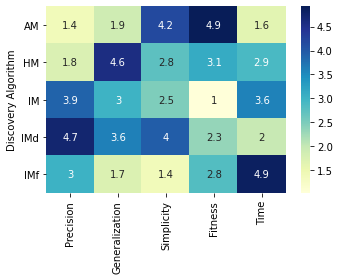

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

metrics = [
    "precision_rank",
    "generalization_rank",
    "simplicity_rank",
    "log_fitness_rank",
    "discovery_time_rank"
]

final_rank = df_models.groupby('variant')[metrics].mean()
final_rank.columns = ["Precision", "Generalization", "Simplicity", "Fitness", "Time"]
final_rank.index.name = "Discovery Algorithm"

plt.figure(figsize=(5, 4))
img = sns.heatmap(final_rank, annot=True, cmap="YlGnBu")
plt.yticks(rotation=0)
plt.tight_layout()


### Creating meta-database

In [33]:
# Rotulating meta-target using the mean rankings
df_models["target_final_rank"] = df_models.filter(metrics).mean(axis=1)

# Finding the best techniques (ranking = min)
best = pd.DataFrame(df_models.groupby("log")["target_final_rank"].min())
best.reset_index(level=0, inplace=True)

# Filtering meta-instances where target_final_rank = min
meta_target = df_models.set_index(["log", "target_final_rank"]).join(best.set_index("log", "target_final_rank"))
meta_target.reset_index(level=0, inplace=True)
meta_target = meta_target[meta_target.index == meta_target.target_final_rank]
meta_target.reset_index(drop=True, inplace=True)

# Removing repetitions
meta_target.drop_duplicates(subset="log", keep=False, inplace=True)

meta_database = meta_target.filter(["log", "variant"]).set_index(["log"]).join(df_logs.set_index("log"))
meta_database.reset_index(level=0, inplace=True)
meta_database


,log,variant,n_traces,n_unique_traces,ratio_unique_traces_per_trace,n_events,trace_len_min,trace_len_max,trace_len_mean,trace_len_median,trace_len_mode,trace_len_std,trace_len_variance,trace_len_q1,trace_len_q3,trace_len_iqr,trace_len_geometric_mean,trace_len_geometric_std,trace_len_harmonic_mean,trace_len_skewness,trace_len_kurtosis,trace_len_coefficient_variation,trace_len_entropy,trace_len_hist1,trace_len_hist2,trace_len_hist3,trace_len_hist4,trace_len_hist5,trace_len_hist6,trace_len_hist7,trace_len_hist8,trace_len_hist9,trace_len_hist10,trace_len_skewness_hist,trace_len_kurtosis_hist,ratio_most_common_variant,ratio_top_1_variants,ratio_top_5_variants,ratio_top_10_variants,ratio_top_20_variants,...,activities_iqr,activities_skewness,activities_kurtosis,n_unique_start_activities,start_activities_min,start_activities_max,start_activities_mean,start_activities_median,start_activities_std,start_activities_variance,start_activities_q1,start_activities_q3,start_activities_iqr,start_activities_skewness,start_activities_kurtosis,n_unique_end_activities,end_activities_min,end_activities_max,end_activities_mean,end_activities_median,end_activities_std,end_activities_variance,end_activities_q1,end_activities_q3,end_activities_iqr,end_activities_skewness,end_activities_kurtosis,entropy_trace,entropy_prefix,entropy_global_block,entropy_lempel_ziv,entropy_k_block_diff_1,entropy_k_block_diff_3,entropy_k_block_diff_5,entropy_k_block_ratio_1,entropy_k_block_ratio_3,entropy_k_block_ratio_5,entropy_knn_3,entropy_knn_5,entropy_knn_7
0,bpi_2012_A,IM,13087,17,0.001299,60849,3,8,4.649576,4.0,3,1.882808,3.544965,3.0,6.0,3.0,4.309628,1.464974,4.028236,0.731763,-0.966721,0.404942,9.401915,0.884695,0.000000,0.334378,0.000000,0.064491,0.000000,0.373195,0.000000,0.000000,0.343241,1.391334,1.022865,0.436999,0.000000,0.000000,0.436999,0.646367,...,5181.75,0.764459,-0.794840,1,13087,13087,13087.000000,13087.0,0.000000,0.000000e+00,13087.00,13087.00,0.00,0.000000,-3.000000,8,3,7635,1635.875000,630.0,2416.367751,5.838833e+06,262.50,1441.25,1178.75,1.812261,1.824614,2.838,3.452,5.839,0.008,3.027,3.027,3.027,3.027,3.027,3.027,1.151,0.727,0.719
1,bpi_2012_W,AM,9658,2643,0.273659,170107,2,156,17.613067,14.0,3,15.986745,255.576002,5.0,25.0,20.0,11.685828,2.592474,7.596637,2.002149,7.226360,0.907664,8.823251,0.038888,0.016694,0.006354,0.001903,0.000585,0.000296,0.000087,0.000067,0.000020,0.000040,1.989750,2.614140,0.193829,0.445434,0.620522,0.701077,0.772106,...,29988.00,0.364298,-1.258906,3,67,4852,3219.333333,4739.0,2229.513599,4.970731e+06,2403.00,4795.50,2392.50,-0.705745,-1.500000,7,4,2749,1379.714286,1802.0,1084.394197,1.175911e+06,256.50,2295.00,2038.50,-0.169172,-1.723262,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,bpi_2013_closed_problems,AM,1487,183,0.123067,6660,1,35,4.478816,3.0,2,3.170888,10.054528,2.0,6.0,4.0,3.734439,1.778468,3.226559,2.669671,12.858932,0.707974,7.109269,0.183552,0.077337,0.021164,0.007516,0.002374,0.001385,0.000198,0.000198,0.000198,0.000198,2.044144,2.773142,0.331540,0.331540,0.776732,0.840619,0.886348,...,1569.00,0.739218,-0.946666,4,1,1432,371.750000,27.0,612.503622,3.751607e+05,1.00,397.75,396.75,1.150575,-0.669945,1,1487,1487,1487.000000,1487.0,0.000000,0.000000e+00,1487.00,1487.00,0.00,0.000000,-3.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3,bpi_2013_incidents,IMd,7554,1511,0.200026,65533,1,123,8.675271,6.0,3,7.625071,58.141705,4.0,11.0,7.0,6.732566,1.963821,5.525513,3.442719,23.107478,0.878943,8.654824,0.068697,0.010319,0.002094,0.000488,0.000250,0.000065,0.000022,0.000011,0.000000,0.000022,2.565201,4.765122,0.232195,0.595976,0.744241,0.794414,0.839952,...,11770.25,0.699956,-0.897909,3,4,6394,2518.000000,1156.0,2780.804200,7.732872e+06,580.00,3775.00,3195.00,0.617184,-1.500000,2,8,7546,3777.000000,3777.0,3769.000000,1.420536e+07,1892.50,5661.50,3769.00,0.000000,-2.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000

### Classification performance

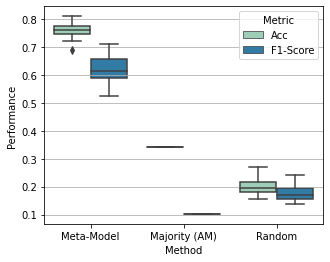

In [83]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score


label = meta_database["variant"].astype("category").cat.codes
X = meta_database.drop(["log", "variant"], axis=1)

# Meta-model predicting the best discovery technique based on log features
result_df = pd.DataFrame()
for step in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, label, stratify=label, random_state=step)
    
    rf = RandomForestClassifier(random_state=step)
    rf.fit(X_train, y_train)

    result = rf.predict(X_test)
    result_df = pd.concat([result_df, pd.DataFrame([[rf.score(X_test, y_test), f1_score(y_test, result, average='macro')]])])

result_df.columns = ["Acc", "F1-Score"]
result_df["Metric"] = "Meta-Model"


# Random approach
result_df_rnd = pd.DataFrame()
for step in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, label, stratify=label, random_state=step)
    
    random_y = np.random.randint(len(label.unique()), size=(1, len(y_test)))
    result_df_rnd = pd.concat([result_df_rnd, pd.DataFrame([[accuracy_score(y_test.values,random_y[0]), f1_score(y_test.values, random_y[0], average='macro')]])])

result_df_rnd.columns = ["Acc", "F1-Score"]
result_df_rnd["Metric"] = "Random"


# Majority approach (AM)
result_df_maj = pd.DataFrame()
for step in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, label, stratify=label, random_state=step)
    
    majority_y = np.zeros(len(y_test))
    result_df_maj = pd.concat([result_df_maj, pd.DataFrame([[accuracy_score(y_test.values, majority_y), f1_score(y_test.values, majority_y, average='macro')]])])

result_df_maj.columns = ["Acc", "F1-Score"]
result_df_maj["Metric"] = "Majority (AM)"


# Plotting
dataset_for_seaborn = pd.melt(pd.concat([result_df, result_df_maj, result_df_rnd]), id_vars="Metric")
dataset_for_seaborn.columns = ["Method", "Metric", "Performance"]

plt.figure(figsize=(5, 4))
ax = sns.boxplot(x="Method", y="Performance", hue="Metric", data=dataset_for_seaborn, palette="YlGnBu")
ax.yaxis.grid(True)

### Analyzing feature importance

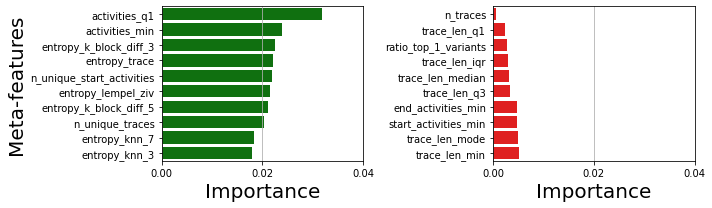

In [82]:
X = meta_database.drop(["log", "variant"], axis=1)
y = meta_database["variant"].astype("category").cat.codes


rf = RandomForestClassifier(random_state=43)
rf.fit(X, y)

importances = pd.DataFrame(rf.feature_importances_)
importances = pd.concat([pd.DataFrame(X.columns),importances], axis=1)
importances.columns = ["Feature", "Importance"]

importances_top = importances.sort_values("Importance", ascending=False)
importances_bottom = importances.sort_values("Importance", ascending=True)


fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

# Top 10 most important features
sns.barplot(ax=axs[0], x="Importance", y="Feature", data=importances_top[:10], color="g", orient="h")
axs[0].set_xlabel("Importance", fontsize=20)
axs[0].set_ylabel("Meta-features", fontsize=20)
axs[0].set_xticks([0, 0.02, 0.04])
axs[0].xaxis.grid(True)


# Bottom 10 lowest important features
sns.barplot(ax=axs[1], x="Importance", y="Feature", data=importances_bottom[:10], color="r", orient="h")
axs[1].set_xlabel("Importance", fontsize=20)
axs[1].set_ylabel("")
axs[1].set_xticks([0, 0.02, 0.04])
axs[1].xaxis.grid(True)

plt.tight_layout()

# Traditional Discovery Algorithms

Discovery algorithm rankings across all event logs considering each dimension. Given event log features, the methods indicate the discovery algorithm that maximizes model quality. This experiment compares three discovery algorithms (IM, HM, AM) using four model quality criteria (fitness, precision, generalization and simplicity)

### Ranking meta-features

In [84]:
# Removing IMf and IMd
df_models = df_models[df_models.variant != "IMf"].copy()
df_models = df_models[df_models.variant != "IMd"].copy()
df_models

# Model metric rankings
df_models['log_fitness_rank'] = df_models.groupby("log")['log_fitness'].rank(method="min", ascending=False, na_option="bottom")
df_models['precision_rank'] = df_models.groupby("log")['precision'].rank(method="min", ascending=False, na_option="bottom")
df_models['generalization_rank'] = df_models.groupby("log")['generalization'].rank(method="min", ascending=False, na_option="bottom")
df_models['simplicity_rank'] = df_models.groupby("log")['simplicity'].rank(method="min", ascending=False, na_option="bottom")

# Time ranks
df_models['discovery_time_rank'] = df_models.groupby("log")['discovery_time'].rank(method="min", ascending=True, na_option="bottom")
df_models['fitness_time_rank'] = df_models.groupby("log")['fitness_time'].rank(method="min", ascending=True, na_option="bottom")
df_models['precision_time_rank'] = df_models.groupby("log")['precision_time'].rank(method="min", ascending=True, na_option="bottom")
df_models['generalization_time_rank'] = df_models.groupby("log")['generalization_time'].rank(method="min", ascending=True, na_option="bottom")
df_models['simplicity_time_rank'] = df_models.groupby("log")['simplicity_time'].rank(method="min", ascending=True, na_option="bottom")

df_models

,log,variant,discovery_time,fitness_time,precision_time,generalization_time,simplicity_time,perc_fit_traces,average_trace_fitness,log_fitness,precision,generalization,simplicity,log_fitness_rank,precision_rank,generalization_rank,simplicity_rank,discovery_time_rank,fitness_time_rank,precision_time_rank,generalization_time_rank,simplicity_time_rank,target_final_rank
0,bpi_2012,IM,29.949167,28.400423,2499.801582,27.818357,0.000240,100.000000,1.000000,1.000000,0.113250,0.965644,0.597070,1.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.2
3,bpi_2012,HM,0.617476,20.320772,214.457781,20.716466,0.000224,62.558264,0.989454,0.981714,0.277102,0.925972,0.553398,2.0,1.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.8
4,bpi_2012,AM,0.492422,10.401784,153.425499,10.724555,0.000180,26.201574,0.774039,0.672295,0.102604,0.973593,0.891892,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.8
5,bpi_2012_A,IM,0.057138,0.062717,0.092973,0.073032,0.000119,100.000000,1.000000,1.000000,0.547118,0.982583,0.674419,1.0,3.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0
8,bpi_2012_A,HM,0.165872,0.061836,0.087191,0.067713,0.000106,30.113853,0.858638,0.889625,1.000000,0.888047,0.625000,2.0,1.0,3.0,2.0,3.0,1.0,1.0,1.0,1.0,3.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5448,sudden_trace_noise20_1000_rp,HM,0.031697,0.110897,0.276789,0.120618,0.000113,100.000000,1.000000,1.000000,0.997042,0.848712,0.660377,1.0,2.0,3.0,1.0,3.0,2.0,2.0,2.0,2.0,2.8
5449,sudden_trace_noise20_1000_rp,AM,0.026765,0.175174,0.091590,0.193486,0.000213,0.000000,0.639754,0.621998,1.000000,0.951659,0.475410,3.0,1.0,1.0,3.0,2.0,3.0,1.0,3.0,3.0,3.2
5450,sudden_trace_noise20_1000_sw,IM,0.023263,0.113297,0.310043,0.106248,0.000098,100.000000,1.000000,1.000000,0.468035,0.946126,0.634409,1.0,3.0,2.0,1.0,1.0,2.0,3.0,2.0,1.0,2.4
5453,sudden_trace_noise20_1000_sw,HM,0.031218,0.099508,0.258155,0.098537,0.000104,55.800000,0.975533,0.974366,0.941654,0.855271,0.625000,2.0,2.0,3.0,2.0,3.0,1.0,2.0,1.0,2.0,3.6


### Metrics ranking

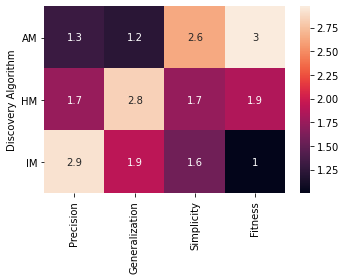

In [85]:
metrics = [
    "precision_rank",
    "generalization_rank",
    "simplicity_rank",
    "log_fitness_rank"
]

final_rank = df_models.groupby('variant')[metrics].mean()
final_rank.columns = ["Precision", "Generalization", "Simplicity", "Fitness"]
final_rank.index.name = "Discovery Algorithm"

plt.figure(figsize=(5, 4))
img = sns.heatmap(final_rank, annot=True)
plt.yticks(rotation=0)
plt.tight_layout()


### Creating meta-database

In [86]:
# Rotulating meta-target using the mean rankings
df_models["target_final_rank"] = df_models.filter(metrics).mean(axis=1)

# Finding the best techniques (ranking = min)
best = pd.DataFrame(df_models.groupby("log")["target_final_rank"].min())
best.reset_index(level=0, inplace=True)

# Filtering meta-instances where target_final_rank = min
meta_target = df_models.set_index(["log", "target_final_rank"]).join(best.set_index("log", "target_final_rank"))
meta_target.reset_index(level=0, inplace=True)
meta_target = meta_target[meta_target.index == meta_target.target_final_rank]
meta_target.reset_index(drop=True, inplace=True)

# Removing repetitions
meta_target.drop_duplicates(subset="log", keep=False, inplace=True)

meta_database = meta_target.filter(["log", "variant"]).set_index(["log"]).join(df_logs.set_index("log"))
meta_database.reset_index(level=0, inplace=True)
meta_database

meta_database = meta_target.filter(["log", "variant"]).set_index(["log"]).join(df_logs.set_index("log"))
meta_database.reset_index(level=0, inplace=True)
meta_database


,log,variant,n_traces,n_unique_traces,ratio_unique_traces_per_trace,n_events,trace_len_min,trace_len_max,trace_len_mean,trace_len_median,trace_len_mode,trace_len_std,trace_len_variance,trace_len_q1,trace_len_q3,trace_len_iqr,trace_len_geometric_mean,trace_len_geometric_std,trace_len_harmonic_mean,trace_len_skewness,trace_len_kurtosis,trace_len_coefficient_variation,trace_len_entropy,trace_len_hist1,trace_len_hist2,trace_len_hist3,trace_len_hist4,trace_len_hist5,trace_len_hist6,trace_len_hist7,trace_len_hist8,trace_len_hist9,trace_len_hist10,trace_len_skewness_hist,trace_len_kurtosis_hist,ratio_most_common_variant,ratio_top_1_variants,ratio_top_5_variants,ratio_top_10_variants,ratio_top_20_variants,...,activities_iqr,activities_skewness,activities_kurtosis,n_unique_start_activities,start_activities_min,start_activities_max,start_activities_mean,start_activities_median,start_activities_std,start_activities_variance,start_activities_q1,start_activities_q3,start_activities_iqr,start_activities_skewness,start_activities_kurtosis,n_unique_end_activities,end_activities_min,end_activities_max,end_activities_mean,end_activities_median,end_activities_std,end_activities_variance,end_activities_q1,end_activities_q3,end_activities_iqr,end_activities_skewness,end_activities_kurtosis,entropy_trace,entropy_prefix,entropy_global_block,entropy_lempel_ziv,entropy_k_block_diff_1,entropy_k_block_diff_3,entropy_k_block_diff_5,entropy_k_block_ratio_1,entropy_k_block_ratio_3,entropy_k_block_ratio_5,entropy_knn_3,entropy_knn_5,entropy_knn_7
0,bpi_2012,IM,13087,4379,0.334607,262200,3,175,20.035149,11.0,3,19.943559,397.745536,3.0,31.0,28.0,11.807100,2.934917,7.124952,1.618213,3.876497,0.995429,9.042624,0.034732,0.013283,0.006535,0.002279,0.000849,0.000244,0.000120,0.000058,0.000013,0.000027,2.054982,2.926423,0.262016,0.560938,0.644151,0.685489,0.732253,...,10841.00,2.144346,3.692864,1,13087,13087,13087.000000,13087.0,0.000000,0.000000e+00,13087.00,13087.00,0.00,0.000000,-3.000000,11,1,3429,1189.727273,653.0,1162.557767,1.351541e+06,168.00,2087.00,1919.00,0.604934,-1.048214,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,bpi_2012_A,IM,13087,17,0.001299,60849,3,8,4.649576,4.0,3,1.882808,3.544965,3.0,6.0,3.0,4.309628,1.464974,4.028236,0.731763,-0.966721,0.404942,9.401915,0.884695,0.000000,0.334378,0.000000,0.064491,0.000000,0.373195,0.000000,0.000000,0.343241,1.391334,1.022865,0.436999,0.000000,0.000000,0.436999,0.646367,...,5181.75,0.764459,-0.794840,1,13087,13087,13087.000000,13087.0,0.000000,0.000000e+00,13087.00,13087.00,0.00,0.000000,-3.000000,8,3,7635,1635.875000,630.0,2416.367751,5.838833e+06,262.50,1441.25,1178.75,1.812261,1.824614,2.838,3.452,5.839,0.008,3.027,3.027,3.027,3.027,3.027,3.027,1.151,0.727,0.719
2,bpi_2012_O,IM,5015,168,0.033500,31244,3,30,6.230110,5.0,5,3.169158,10.043560,4.0,8.0,4.0,5.682570,1.491033,5.304181,2.281176,6.899116,0.508684,8.415881,0.264170,0.029246,0.047266,0.017208,0.006204,0.003176,0.001920,0.000443,0.000517,0.000222,2.494657,4.542380,0.306481,0.306481,0.798804,0.891326,0.946760,...,4181.50,-0.114659,-1.514451,1,5015,5015,5015.000000,5015.0,0.000000,0.000000e+00,5015.00,5015.00,0.00,0.000000,-3.000000,5,89,2243,1003.000000,802.0,824.598084,6.799620e+05,241.00,1640.00,1399.00,0.339213,-1.457644,3.753,4.535,6.981,0.107,-0.273,0.426,0.285,0.769,2.574,1.500,2.740,2.392,2.208
3,bpi_2012_W,AM,9658,2643,0.273659,170107,2,156,17.613067,14.0,3,15.986745,255.576002,5.0,25.0,20.0,11.685828,2.592474,7.596637,2.002149,7.226360,0.907664,8.823251,0.038888,0.016694,0.006354,0.001903,0.000585,0.000296,0.000087,0.000067,0.000020,0.000040,1.989750,2.614140,0.193829,0.445434,0.620522,0.701077,0.772106,...,29988.00,0.364298,-1.258906,3,67,4852,3219.333333,4739.0,2229.513599,4.970731e+06,2403.00,4795.50,2392.50,-0.705745,-1.500000,7,4,2749,1379.714286,1802.0,1084.394197,1.175911e+06,256.50,2295.00,2038.50,-0.169172,-1.723262,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
4,bpi_

### Classification performance

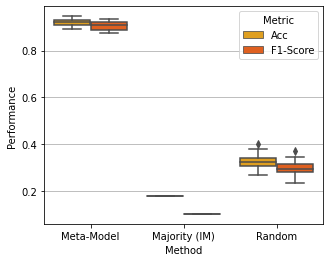

In [88]:
label = meta_database["variant"].astype("category").cat.codes
X = meta_database.drop(["log", "variant"], axis=1)

# Meta-model predicting the best discovery technique based on log features
result_df = pd.DataFrame()
for step in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, label, stratify=label, random_state=step)
    
    rf = RandomForestClassifier(random_state=step)
    rf.fit(X_train, y_train)

    result = rf.predict(X_test)
    result_df = pd.concat([result_df, pd.DataFrame([[rf.score(X_test, y_test), f1_score(y_test, result, average='macro')]])])

result_df.columns = ["Acc", "F1-Score"]
result_df["Metric"] = "Meta-Model"


# Random approach
result_df_rnd = pd.DataFrame()
for step in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, label, stratify=label, random_state=step)
    
    random_y = np.random.randint(len(label.unique()), size=(1, len(y_test)))
    result_df_rnd = pd.concat([result_df_rnd, pd.DataFrame([[accuracy_score(y_test.values,random_y[0]), f1_score(y_test.values, random_y[0], average='macro')]])])

result_df_rnd.columns = ["Acc", "F1-Score"]
result_df_rnd["Metric"] = "Random"


# Majority approach (IM)
result_df_maj = pd.DataFrame()
for step in range(30):
    X_train, X_test, y_train, y_test = train_test_split(X, label, stratify=label, random_state=step)
    
    majority_y = np.zeros(len(y_test))
    result_df_maj = pd.concat([result_df_maj, pd.DataFrame([[accuracy_score(y_test.values, majority_y), f1_score(y_test.values, majority_y, average='macro')]])])

result_df_maj.columns = ["Acc", "F1-Score"]
result_df_maj["Metric"] = "Majority (IM)"


# Plotting
dataset_for_seaborn = pd.melt(pd.concat([result_df, result_df_maj, result_df_rnd]), id_vars="Metric")
dataset_for_seaborn.columns = ["Method", "Metric", "Performance"]

plt.figure(figsize=(5, 4))
ax = sns.boxplot(x="Method", y="Performance", hue="Metric", data=dataset_for_seaborn, palette="autumn_r")
ax.yaxis.grid(True)

### Analyzing feature importance

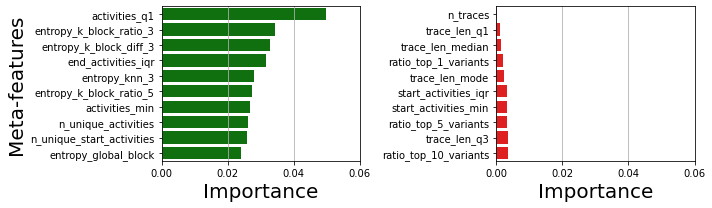

In [89]:
X = meta_database.drop(["log", "variant"], axis=1)
y = meta_database["variant"].astype("category").cat.codes


rf = RandomForestClassifier(random_state=43)
rf.fit(X, y)

importances = pd.DataFrame(rf.feature_importances_)
importances = pd.concat([pd.DataFrame(X.columns),importances], axis=1)
importances.columns = ["Feature", "Importance"]

importances_top = importances.sort_values("Importance", ascending=False)
importances_bottom = importances.sort_values("Importance", ascending=True)


fig, axs = plt.subplots(ncols=2, figsize=(10, 3))

# Top 10 most important features
sns.barplot(ax=axs[0], x="Importance", y="Feature", data=importances_top[:10], color="g", orient="h")
axs[0].set_xlabel("Importance", fontsize=20)
axs[0].set_ylabel("Meta-features", fontsize=20)
axs[0].set_xticks([0, 0.02, 0.04, 0.06])
axs[0].xaxis.grid(True)


# Bottom 10 lowest important features
sns.barplot(ax=axs[1], x="Importance", y="Feature", data=importances_bottom[:10], color="r", orient="h")
axs[1].set_xlabel("Importance", fontsize=20)
axs[1].set_ylabel("")
axs[1].set_xticks([0, 0.02, 0.04, 0.06])
axs[1].xaxis.grid(True)

plt.tight_layout()